In [22]:
import pandas as pd
import numpy as np
import pyabf
import matplotlib.pyplot as plt
from scipy import stats, signal, optimize
from sklearn.linear_model import LinearRegression

In [2]:
    def Analyse_IntrinsicProfile(V, I, t, sr, plotting):

        #Start-end current command
        dI = np.insert(np.diff(I),0,0)
        I_peaks,_ = signal.find_peaks(dI,height=10)
        if np.shape(I_peaks)[0]:
            I_ON = np.argmax(dI)
            I_OFF = np.argmin(dI)

            if I_ON > I_OFF: #Invert ON and OFF for negative current steps
                I_OFF = np.argmax(dI)
                I_ON = np.argmin(dI)

            commandDuration=t[I_OFF]-t[I_ON]
            I_command=np.round(np.mean(I[I_ON+int(0.1*sr):I_ON+int(0.2*sr)])-np.mean(I[I_ON-int(0.2*sr):I_ON-int(0.1*sr)]))

            # Find hyperpolarization-induced voltage sag
            if I_command < 0:
                V_Ih_inst_idx = np.argmin(V[I_ON:I_OFF])+I_ON
                V_Ih_inst = V[V_Ih_inst_idx]
                V_Ih_ss = V[I_OFF]
                V_Ih = V_Ih_ss - V_Ih_inst
                
            else:
                V_Ih = np.nan
                V_Ih_ss = np.nan
            
            #Find firing frequency: number action potentials (APs)
            V_peaks, _ = signal.find_peaks(V[I_ON:I_OFF],height=-20,prominence=10)            
            AP_firingFrequency = np.shape(V_peaks)[0]/commandDuration
            
            if np.shape(V_peaks)[0] != 0:
                #Find firing frequency adaptation
                adaptationWindow = 0.1
                spikeN_i = np.count_nonzero((V_peaks)<adaptationWindow *sr)
                spikeN_f = np.count_nonzero(((V_peaks)>(commandDuration-adaptationWindow)*sr) & ((V_peaks)<commandDuration*sr))
                if spikeN_i != 0:
                    AP_adaptation = (spikeN_i-spikeN_f)/spikeN_i*100
                else:
                    AP_adaptation  = np.nan

            else:
                AP_adaptation  = np.nan
        
            if np.shape(V_peaks)[0] in [1,2,3] and I_command < 200:
                V_peaks = V_peaks + I_ON
                if np.shape(V_peaks)[0] in [2,3]:
                    end_idx = (V_peaks)[1]
                else:
                    end_idx = I_OFF
                
                #Find rheobase
                rheobase = I_command
                
                AP_window = np.arange(V_peaks[0]-int(0.03*sr),end_idx)
                AP_threshold, AP_spikeHeight, AP_halfWidth, AP_fAHP = Analyse_Spike(V[AP_window], t[AP_window], sr, int(0.03*sr), plotting)

            else:
                rheobase = np.nan
                AP_threshold = np.nan
                AP_spikeHeight = np.nan
                AP_halfWidth = np.nan
                AP_fAHP = np.nan
        
        elif not np.shape(I_peaks)[0] and np.mean(V[int(0.5*sr):int(0.55*sr)]) > np.mean(V[int(0.45*sr):int(0.5*sr)]) + 3*np.std(V[int(0.45*sr):int(0.5*sr)]):
            
            I_ON = int(0.5*sr)
            I_OFF = int(1*sr)
            commandDuration = 0.5
            I_command = np.nan
            V_Ih = np.nan
            V_Ih_ss = np.nan
            
            #Find firing frequency: number action potentials (APs)
            V_peaks, _ = signal.find_peaks(V[I_ON:I_OFF],height=-20,prominence=10)            
            AP_firingFrequency = np.shape(V_peaks)[0]/commandDuration
            
            if np.shape(V_peaks)[0] != 0:
                #Find firing frequency adaptation
                adaptationWindow = 0.1
                spikeN_i = np.count_nonzero((V_peaks)<adaptationWindow *sr)
                spikeN_f = np.count_nonzero(((V_peaks)>(commandDuration-adaptationWindow)*sr) & ((V_peaks)<commandDuration*sr))
                if spikeN_i != 0:
                    AP_adaptation = (spikeN_i-spikeN_f)/spikeN_i*100
                else:
                    AP_adaptation  = np.nan

            else:
                AP_adaptation  = np.nan
        
            if np.shape(V_peaks)[0] in [1,2,3]:
                V_peaks = V_peaks + I_ON
                if np.shape(V_peaks)[0] in [2,3]:
                    end_idx = (V_peaks)[1]
                else:
                    end_idx = I_OFF
                
                #Find rheobase
                rheobase = I_command
                
                AP_window = np.arange(V_peaks[0]-int(0.03*sr),end_idx)
                AP_threshold, AP_spikeHeight, AP_halfWidth, AP_fAHP = Analyse_Spike(V[AP_window], t[AP_window], sr, int(0.03*sr), plotting)

            else:
                rheobase = np.nan
                AP_threshold = np.nan
                AP_spikeHeight = np.nan
                AP_halfWidth = np.nan
                AP_fAHP = np.nan
        
        elif not np.shape(I_peaks)[0] and np.mean(V[int(0.5*sr):int(0.55*sr)]) < np.mean(V[int(0.45*sr):int(0.5*sr)]) + 3*np.std(V[int(0.45*sr):int(0.5*sr)]):
            
            I_ON = int(0.5*sr)
            I_OFF = int(1*sr)
            commandDuration = 0.5
            I_command = np.nan
            rheobase = np.nan
            AP_threshold = np.nan
            AP_spikeHeight = np.nan
            AP_halfWidth = np.nan
            AP_fAHP = np.nan
            AP_firingFrequency = np.nan
            AP_adaptation = np.nan

            
            # Find hyperpolarization-induced voltage sag
            V_Ih_inst_idx = np.argmin(V[I_ON:I_OFF])+I_ON
            V_Ih_inst = V[V_Ih_inst_idx]
            V_Ih_ss = V[I_OFF]
            V_Ih = V_Ih_ss - V_Ih_inst
                          
            
        else:
            commandDuration = 0.5
            I_command = 0
            I_ON = int(0.5*sr)
            V_Ih = np.nan
            V_Ih_ss = np.nan
            AP_firingFrequency = np.nan
            rheobase = np.nan
            AP_threshold = np.nan
            AP_spikeHeight = np.nan
            AP_halfWidth = np.nan
            AP_fAHP = np.nan
            AP_adaptation = np.nan

        #Find resting membrane potential
        RMP = np.mean(V[0:I_ON-int(0.05*sr)])
        
        return [commandDuration,I_command,RMP,AP_firingFrequency,V_Ih,V_Ih_ss,rheobase,AP_threshold,AP_spikeHeight,AP_halfWidth,AP_fAHP,AP_adaptation]


In [3]:
    def Analyse_Rin(V, I, t, sr, plotting):
        #Start-end current command
        dI = np.insert(np.diff(I),0,0)
        I_peaks,_ = signal.find_peaks(dI,height=5)
        if np.shape(I_peaks)[0]:
            I_ON = np.argmax(dI)
            I_OFF = np.argmin(dI)

            if I_ON > I_OFF: #Invert ON and OFF for negative current steps
                I_OFF = np.argmax(dI)
                I_ON = np.argmin(dI)

            commandDuration=t[I_OFF]-t[I_ON]
            deltaI=np.round(np.mean(I[I_ON+int(0.01*sr):I_ON+int(0.02*sr)])-np.mean(I[I_ON-int(0.02*sr):I_ON-int(0.01*sr)]))
        
        else:
            Vf = butter_lowpass_filter(V-V[0], 200, sr, 2)
            dV = np.insert(np.diff(Vf,n=1),0,0)
            I_ON = np.argmin(dV)-100
            I_OFF = np.argmax(dV)-100
            deltaI = 10 #pA

        
        #Find input resistance (Rin) in MOhm
        deltaV = np.mean(V[I_ON-int(0.05*sr):I_ON])-np.mean(V[I_OFF-int(0.05*sr):I_OFF])  
        Rin = abs(deltaV/deltaI*1000)
        
        #Find decay time constant
        if (I_OFF-I_ON)/sr > 0.3:
            fitOFF = I_ON+int(0.2*sr)
        else:
            fitOFF = I_OFF  
        
        def mono_exp(x, a, b):
             return a * np.exp(b * x)

        xfit = t[I_ON:fitOFF]
        yfit = V[I_ON:fitOFF]-np.mean(V[fitOFF-int(0.005*sr):fitOFF])
        popt,pcov = optimize.curve_fit(mono_exp, xfit, yfit, method = 'lm', maxfev = 15000, ftol = 10**-10)
        Tau = 1/(-popt[1])     
            
        #Plot tau fitting
        if plotting:
            plt.figure()
            plt.plot(xfit, yfit, 'k', label="Data")
            plt.plot(xfit, mono_exp(xfit, *popt), 'r-', label="Fitted Curve")            
            plt.legend()
            plt.show()
            
        return Rin, Tau

In [5]:
    def Analyse_Baseline(V, I, t, sr, plotting):
        
        RMP = np.mean(V[0:int(0.05*sr)])
        V_peaks, _ = signal.find_peaks(V,height=-20)            
        rheobase = I[V_peaks[0]]
        
        if np.shape(V_peaks)[0]>=1:
            AP_window = np.arange(V_peaks[0]-int(0.03*sr),V_peaks[0]+int(0.1*sr))
            AP_threshold, AP_spikeHeight, AP_halfWidth, AP_fAHP = Analyse_Spike(V[AP_window], t[AP_window], sr, int(0.03*sr), plotting)
        elif np.shape(V_peaks)[0]==0:
            print("ERROR: no action potential detected in baseline file")
        
        return (RMP, rheobase, AP_threshold, AP_spikeHeight, AP_halfWidth, AP_fAHP)

In [6]:
    def Analyse_Spike(V, t, sr, spikeIdx, plotting):
        #Find AP threshold: first derivative method, 20 % peak velocity cut-off
        dV = np.insert(np.diff(V,n=1),0,0)
        dV_peaks, _ = signal.find_peaks(dV,height=1)
        Th_idx = np.argmin(abs(dV[:dV_peaks[0]]-dV[dV_peaks][0]*0.05))
        AP_threshold = V[Th_idx]
        
        #Find AP height
        AP_peakHeight = V[spikeIdx]
        AP_spikeHeight = AP_peakHeight-AP_threshold
        
        #Find AP half-width
        AP_halfHeigth = AP_spikeHeight/2
        Half_Start = np.argmin(abs(V[Th_idx:spikeIdx]-(AP_peakHeight-AP_halfHeigth)))+Th_idx
        Half_End = np.argmin(abs(V[spikeIdx:]-(AP_peakHeight-AP_halfHeigth)))+spikeIdx
        AP_halfWidth = t[Half_End]-t[Half_Start]

        #Find fast AHP (fAHP) amplitude
        fAHP_idx = np.argmin(V[spikeIdx:])+spikeIdx
        AP_fAHP = AP_threshold - V[fAHP_idx]
        
        #Plot AP and points of interest
        if plotting:
            plt.figure()
            plt.plot(t,V)
            plt.plot(t[spikeIdx],V[spikeIdx],'rx')
            plt.plot(t[Th_idx],V[Th_idx],'bx')
            plt.plot(t[Half_Start],V[Half_Start],'bx')
            plt.plot(t[Half_End],V[Half_End],'bx')
            plt.plot(t[fAHP_idx],V[fAHP_idx],'bx')              

        return(AP_threshold, AP_spikeHeight, AP_halfWidth, AP_fAHP)

In [65]:
    def Analyse_Neuron(neuron):
        plotting = 0
        # Initialise dataframe for single cell data 
        cols=['CommandDuration','CommandAmplitude','RMP','FiringFrequency','VoltageSag','V_Ih_SS','Rheobase','Threshold','SpikeHeight','SpikeHalfWidth','fAHPamplitude','Adaptation']
        neuronResults=pd.DataFrame(columns=cols)

        for i, file in enumerate(neuron.filename):
            if i == 0:
                neuron.reset_index(inplace=True, drop=True)
        
            abf = pyabf.ABF(neuron.foldername[i]+"\\"+cellID+"\\"+file)
            print("Analysing"+file)
        
            for sweep in range(abf.sweepCount):    
                #Set voltage, current, time
                abf.setSweep(sweepNumber=sweep, channel=0)
                t = abf.sweepX
                V = abf.sweepY
                abf.setSweep(sweepNumber=sweep, channel=1)
                I = abf.sweepY
                sr = abf.dataRate
    
                if neuron.filetype[i]=='IntrinsicProfile':  
                    neuronResults.loc[len(neuronResults), :] = Analyse_IntrinsicProfile(V, I, t, sr, plotting)

                elif neuron.filetype[i]=='Rin':
                    Rin, Tau = Analyse_Rin(V, I, t, sr, plotting)

                elif neuron.filetype[i]=='Baseline':
                    RMP, rheobase, AP_threshold, AP_spikeHeight, AP_halfWidth, AP_fAHP = Analyse_Baseline(V, I, t, sr, plotting)
        
            
        if 'RMP' not in locals(): # Case there is not baseline file recorded
            print("No RMP")
            #RMP = np.mean(neuronResults.RMP)
            #rheobase = np.mean(neuronResults.Rheobase)
            #AP_threshold = np.mean(neuronResults.Threshold)
            #AP_spikeHeight = np.mean(neuronResults.SpikeHeight)
            #AP_halfWidth = np.mean(neuronResults.SpikeHalfWidth)
            #AP_fAHP = np.mean(neuronResults.fAHPamplitude)
            
            RMP = np.nan
            rheobase = np.nan
            AP_threshold = np.nan
            AP_spikeHeight = np.nan
            AP_halfWidth = np.nan
            AP_fAHP = np.nan
        
        if rheobase == 0: # Case baseline is recorded without valid current trace
            rheobase = np.mean(neuronResults.Rheobase)
        
        if 'Rin' not in locals():
            print("No Rin")
            Rin = np.nan
            Tau = np.nan
            
        #Build output dataframe
        MaxFiringFrequency = np.max(neuronResults.FiringFrequency)
        if not neuronResults.FiringFrequency.empty:
            Adaptation = neuronResults.Adaptation[neuronResults.FiringFrequency.astype('float64').idxmax()]
            VoltageSag = neuronResults.VoltageSag[np.argmin(abs(neuronResults.V_Ih_SS+100))[0]]
        else:
            print("List is empty")
            Adaptation = np.nan
            VoltageSag = np.nan
            
        if np.isnan(rheobase):
            rheobase = neuron.Rheobase[0]
        
        results = [cellID, neuron.CellTarget[0], 'NaN', RMP, Rin, Tau, rheobase, AP_threshold, AP_spikeHeight, AP_halfWidth, MaxFiringFrequency, Adaptation, AP_fAHP, VoltageSag]
        plt.figure()
        plt.plot(neuronResults.CommandAmplitude,neuronResults.FiringFrequency,'o')
        
        plt.figure()
        plt.plot(neuronResults.CommandAmplitude[0:9],neuronResults.V_Ih_SS[0:9],'o')
        
        
        reg = LinearRegression().fit(np.array(neuronResults.CommandAmplitude[0:9]).reshape(-1,1)/1000,np.array(neuronResults.V_Ih_SS [0:9]).reshape(-1,1))
        print(reg.coef_)
        print(reg.intercept_)
        print(reg.score(np.array(neuronResults.CommandAmplitude[0:9]).reshape(-1,1),np.array(neuronResults.V_Ih_SS [0:9]).reshape(-1,1)))
        print(neuronResults)
        
        return results

SA83.1
Analysing20623000.abf
Analysing20623001.abf
Analysing20623002.abf
[[192.755]]
[-63.6325]
-6138827.893136892
   CommandDuration CommandAmplitude      RMP FiringFrequency VoltageSag  \
0              0.5             -101 -60.6221               0    1.43433   
1              0.5              -91 -60.9757               0   0.610352   
2              0.5              -81 -61.3071               0   0.305176   
3              0.5              -71 -60.8863               0    1.98364   
4              0.5              -60 -60.7468               0  0.0915527   
5              0.5              -50 -60.7386               0   0.457764   
6              0.5              -40 -61.5982               0    1.89209   
7              0.5              -30 -62.2177               0   0.183105   
8              0.5              -20 -60.5776               0  0.0610352   
9              0.5              -10 -60.3711               0   0.793457   
10             0.5              NaN -61.1461             NaN

C:\Users\Butt Lab\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


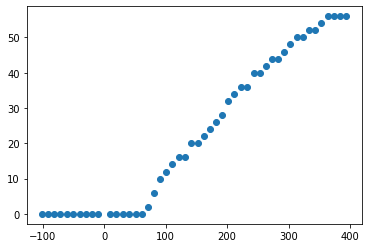

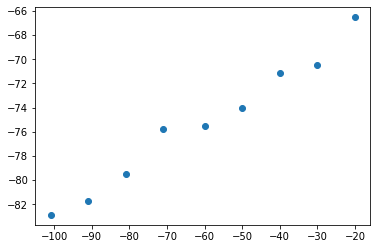

In [67]:
data = pd.read_csv("Trial.csv")
#Initialize results dataframe
resultsColumns = ['Cell_ID','CellTarget','Genotype','RMP','Rin','Tau','Rheobase','Spike_Threshold','Spike_Height','Spike_HalfWidth','MaxFiringFrequency','Adaptation', 'AHP_amplitude', 'VoltageSag']
results = pd.DataFrame(columns=resultsColumns)

for cellID in np.unique(data.Cell_ID):
    print(cellID)
    neuron=data[data.Cell_ID==cellID]
    
    results.loc[len(results), :] = Analyse_Neuron(neuron)
    
    
print(results)
    

In [10]:
neuronResults

NameError: name 'neuronResults' is not defined

In [52]:
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
X

array([[1, 1],
       [1, 2],
       [2, 2],
       [2, 3]])

In [53]:
y = np.dot(X, np.array([1, 2])) + 3
y

array([ 6,  8,  9, 11])

In [14]:
results.to_csv('Results.csv')

In [24]:
#Plot useful stuff
    fig=plt.figure(figsize=(16, 10))
    ax1 = fig.add_subplot(211)
    ax1.plot(t,V)
    #ax2 = fig.add_subplot(212)
    #ax2.plot(t,I)
    #ax1.plot(t[I_ON:I_OFF],V[I_ON:I_OFF])


    if np.shape(V_peaks)[0] != 0:
        #ax1.plot(t[I_ON+int(0.04*sr):V_peaks[0]],V[I_ON+int(0.04*sr):V_peaks[0]]) #Zoom for threshold check
        #ax1.plot(t[I_ON+int(0.04*sr):V_peaks[0]+int(0.01*sr)],V[I_ON+int(0.04*sr):V_peaks[0]+int(0.01*sr)]) #Zoom for threshold check
        ax1.plot(t[V_peaks],V[V_peaks],"rx")

    if np.shape(V_peaks)[0] in [1,2,3]:
        ax1.plot(t[Th_idx],V[Th_idx],"rx")
        ax1.plot(t[Half_Start],V[Half_Start],'rx')
        ax1.plot(t[Half_End],V[Half_End],'rx')
        ax1.plot(t[fAHP_idx],V[fAHP_idx],'rx')


        ax2 = fig.add_subplot(212)
        ax2.plot(t[I_ON+int(0.04*sr):V_peaks[0]],dV[I_ON+int(0.04*sr):V_peaks[0]])
        ax2.plot(t[Th_idx],dV[Th_idx],"rx")

        fig2 = plt.figure(figsize=(16, 10))
        plt.plot(V,dV)

    if I_command < 0:
        ax1.plot(t[V_Ih_inst_idx],V[V_Ih_inst_idx],"rx")
        ax1.plot(t[I_OFF],V[I_OFF],"rx")

    

IndentationError: unexpected indent (<ipython-input-24-583fe65382fe>, line 2)

In [11]:
from scipy.signal import butter, lfilter
def butter_lowpass(lowcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, low, btype='low')
    return b, a


def butter_lowpass_filter(data, lowcut, fs, order):
    b, a = butter_lowpass(lowcut, fs, order)
    y = lfilter(b, a, data)
    return y